In [2]:
import numpy as np
import matplotlib.pyplot as plt
import flika as flk
#flk.start_flika()
from matplotlib.gridspec import GridSpec
from flika.window import Window as flw
import matplotlib 
from scipy.ndimage.filters import median_filter
from dask.array import coarsen
from fish.image.zds import to_dask, ZDS
from fish.util.distributed import get_jobqueue_cluster
from dask.distributed import Client
from fish.util.plot import depth_project

matplotlib.rc('font', family='arial')
matplotlib.rc('font', size=8)
matplotlib.rc('axes', titlesize=8)
matplotlib.rc('axes', labelsize=8)
matplotlib.rc('xtick', labelsize=8)
matplotlib.rc('ytick', labelsize=8)
matplotlib.rc('legend', fontsize=8)

from fish.ephys.ephys import estimate_onset, windowed_variance, estimate_swims, load
from pathlib import Path
from fish.image.alignment import estimate_translation
from h5py import File
from skimage.exposure import rescale_intensity as rescale
from fish.util.plot import apply_cmap
from scipy.signal import fftconvolve
from scipy.stats import zscore
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig_dir = '/groups/ahrens/ahrenslab/davis/tmp/'
%matplotlib inline

In [3]:
def guess_experimenter(path):
    experimenter = None
    if path.find('Yu') >= 0:
        experimenter = 'yu'
    elif path.find('davis') >= 0:
        experimenter = 'davis'
    return experimenter

def get_dset(path):
    from pathlib import Path
    from os.path import exists
    from scipy.ndimage.filters import median_filter
    experimenter = guess_experimenter(path)
    if experimenter == 'davis':
        reg_path = path.replace('raw', 'proc') + 'reg/regparams_affine.npy'        
        dset = ZDS(path)
        
    elif experimenter == 'yu':
        rootdir = str(Path(path).parent) + '/'
        reg_path = rootdir + 'regparams_affine.npy'
        if not exists(reg_path):
            reg_path = rootdir + 'regparams_affine_ds2.npy'
        dset = ZDS(path)
        
    shifts = -np.load(reg_path)[:,:-1,-1]
    shifts = median_filter(shifts, size=(int(200 / dset.metadata['volume_rate']), 1))        
    dset.affines = shifts
    
    return dset

In [4]:
base_dirs = ('/nrs/ahrens/davis/data/spim/raw/20160608/6dpf_cy171xcy221_f1_omr_1_20160608_170933/',
             '/nrs/ahrens/Yu/SPIM/active_dataset/glia_neuron_imaging/20170228/fish3/20170228_3_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_165730/raw/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/glia_neuron_imaging/20170221/fish5/20170221_5_3_gfaprgeco_hucgc_6dpf_wholebrain_20170221_223941/raw/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/glia_neuron_imaging/20170221/fish4/20170221_4_2_gfaprgeco_hucgc_6dpf_wholebrain_20170221_163236/raw/', 
            '/nrs/ahrens/Yu/SPIM/active_dataset/glia_neuron_imaging/20170203/fish1/20170203_1_4_gfapgcamp_hucrgeco_8dpf_wholebrain_CL_0gain_modulation_20170203_122038/raw/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/glia_neuron_imaging/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/raw/')

In [5]:
from fish.util.distributed import get_jobqueue_cluster
cluster = get_jobqueue_cluster()
client = Client(cluster)
client

/groups/ahrens/home/bennettd/miniconda/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://10.36.111.11:44146 Dashboard: http://10.36.111.11:41731/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
dsets = {}
for fn in base_dirs:
    tmp = get_dset(fn)
    dsets[tmp.metadata['data_header']] = tmp

In [7]:
exp_name, dset = (*dsets.items(),)[-1]
data = dset.data
fs_im = dset.metadata['volume_rate']
print(exp_name)

20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials


In [8]:
sample_anat = data[0].compute(scheduler='threads')

In [9]:
def mydff(v, fs_im):
    from fish.image.vol import dff
    camera_offset = 80
    window = 300 * fs_im
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

In [10]:
cluster.start_workers(100)
means = data[:,:,:1024].mean((1,2,3)), data[:,:,1024:].mean((1,2,3))
mean_g, mean_n = client.compute(means, sync=True)
cluster.stop_all_jobs()

(400, 450)

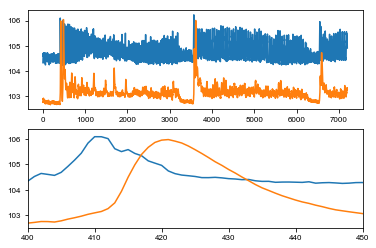

In [11]:
fig, axs = plt.subplots(nrows=2)
plr = slice(400, 450)

axs[0].plot(mean_n)
axs[0].plot(mean_g)

axs[1].plot(mean_n)
axs[1].plot(mean_g)
axs[1].set_xlim(plr.start,plr.stop)

In [12]:
cluster.start_workers(20)
sample = data[plr].astype('float32').map_blocks(lambda v: median_filter(v, size=(1,1,3,3))).compute()
cluster.stop_all_jobs()

In [13]:
sample_dff = (sample / np.percentile(sample, q=20, axis=0)) - 1

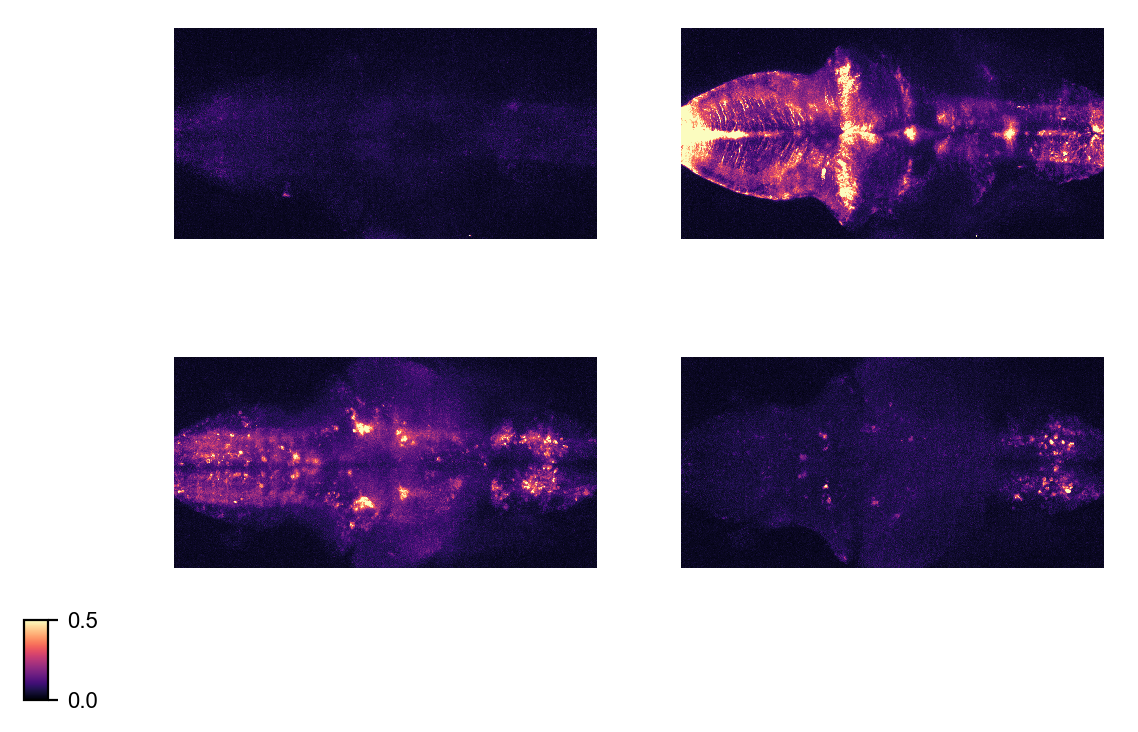

In [19]:
fig, axs = plt.subplots(dpi=200, ncols=2, nrows=2)
ts = [10,24]
cmap='magma'
axs[0,0].imshow(sample_dff[ts[0],:,:1024,::-1].max(0), clim=(0,.5),cmap=cmap)
axs[0,1].imshow(sample_dff[ts[1],:,:1024,::-1].max(0), clim=(0,.5),cmap=cmap)
axs[1,0].imshow(sample_dff[ts[0],:,1024:,::-1].max(0), clim=(0,.5),cmap=cmap)
axs[1,1].imshow(sample_dff[ts[1],:,1024:,::-1].max(0), clim=(0,.5),cmap=cmap)

[ax.axis('off') for ax in axs.ravel()]
axs_cbar = fig.add_axes((0,0,.02,.1))
plt.colorbar(axs[0,0].images[0], cax=axs_cbar)
plt.savefig(fig_dir + exp_name + f'_t{ts[0]}t{ts[-1]}.pdf')